In [17]:
### Run this cell before continuing. 
library(tidyverse)
library(stringr)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
movies_csv <- read_csv("movies.csv")
movies_csv

Rows: 99 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): movie_name, year_of_release, category, run_time, genre, gross_total
dbl (2): index, imdb_rating

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


index,movie_name,year_of_release,category,run_time,genre,imdb_rating,votes,gross_total
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,The Godfather,(1972),R,175 min,"Crime, Drama",9.2,1860471,$134.97M
2,The Silence of the Lambs,(1991),R,118 min,"Crime, Drama, Thriller",8.6,1435344,$130.74M
3,Star Wars: Episode V - The Empire Strikes Back,(1980),PG,124 min,"Action, Adventure, Fantasy",8.7,1294805,$290.48M
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
97,Eternal Sunshine of the Spotless Mind,(2004),R,108 min,"Drama, Romance, Sci-Fi",8.3,1011004,$34.40M
98,City Lights,(1931),G,87 min,"Comedy, Drama, Romance",8.5,186059,$0.02M
99,The Matrix,(1999),R,136 min,"Action, Sci-Fi",8.7,1916083,$171.48M


In [3]:
select_movies <- select(movies_csv, category, run_time, votes, imdb_rating)
select_movies

category,run_time,votes,imdb_rating
<chr>,<chr>,<dbl>,<dbl>
R,175 min,1860471,9.2
R,118 min,1435344,8.6
PG,124 min,1294805,8.7
⋮,⋮,⋮,⋮
R,108 min,1011004,8.3
G,87 min,186059,8.5
R,136 min,1916083,8.7


In [4]:
filter_movies <- filter(select_movies, category != "Approved", category != "Passed", category != "GP")
filter_movies

category,run_time,votes,imdb_rating
<chr>,<chr>,<dbl>,<dbl>
R,175 min,1860471,9.2
R,118 min,1435344,8.6
PG,124 min,1294805,8.7
⋮,⋮,⋮,⋮
R,108 min,1011004,8.3
G,87 min,186059,8.5
R,136 min,1916083,8.7


In [5]:
set.seed(9999) 

mutated_movies <- mutate(filter_movies, category = as_factor(category))
changed_movies <- mutated_movies |>
    mutate(run_time = str_replace_all(run_time, "([min])", ""))|>
    mutate(run_time = as.numeric(run_time))

knn_spec_all <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
       set_engine("kknn") |>
       set_mode("classification")

movies_data_recipe_all <- recipe(category ~ run_time + votes + imdb_rating, data = changed_movies) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

movies_fit_all <- workflow() |>
          add_recipe(movies_data_recipe_all) |>
          add_model(knn_spec_all) |>
          fit(data = changed_movies)

new_movie <- tibble(run_time = 80, 
                            votes = 3947582, 
                            imdb_rating = 5)

movie_all_predicted <- predict(movies_fit_all, new_movie)
movie_all_predicted

.pred_class
<fct>
R


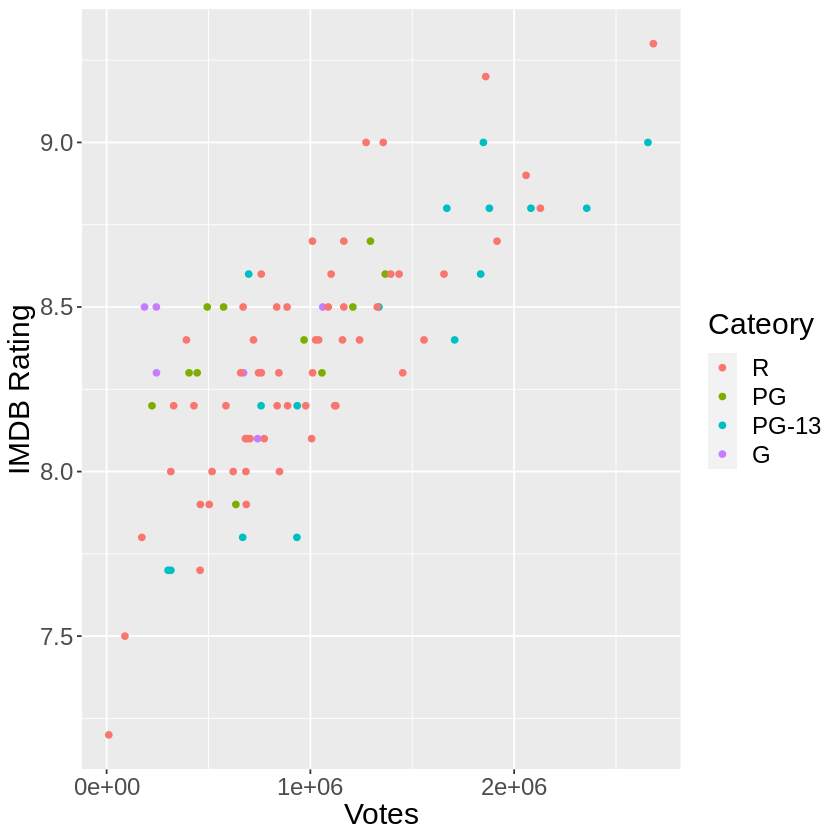

In [6]:
options(repr.plot.height = 7, repr.plot.width = 7)
movies_plot_1 <- ggplot(changed_movies, aes(x = votes, y = imdb_rating))+
    geom_point(aes(color = category))+
    labs(x = "Votes", y = "IMDB Rating", color = "Cateory")+
    theme(text = element_text(size = 18))
movies_plot_1

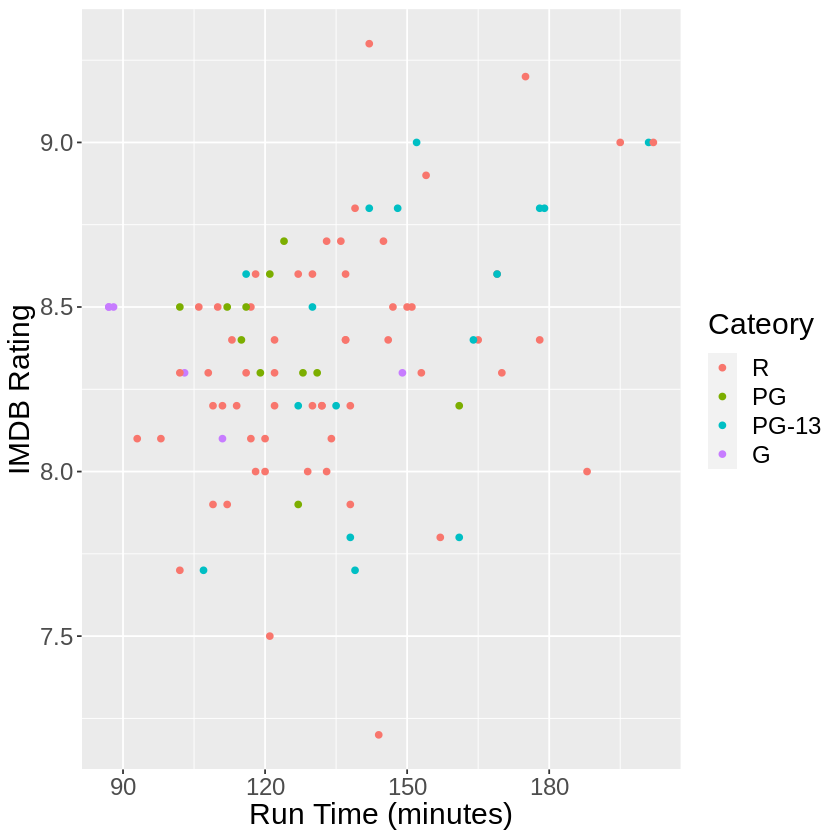

In [7]:
options(repr.plot.height = 7, repr.plot.width = 7)
movies_plot_2 <- ggplot(changed_movies, aes(x = run_time, y = imdb_rating))+
    geom_point(aes(color = category))+
    labs(x = "Run Time (minutes)", y = "IMDB Rating", color = "Cateory")+
    theme(text = element_text(size = 18))
movies_plot_2

In [19]:
movies_split <- initial_split(changed_movies, prop = 0.75, strata = category)  
movies_train <- training(movies_split)   

In [21]:
movies_count <- nrow(movies_train)
movies_train |>
  group_by(category) |>
  summarize(
    count = n())

category,count
<fct>,<int>
R,43
PG,9
PG-13,12
G,2


In [15]:
movies_split <- initial_split(changed_movies, prop = 0.75, strata = category)
training_movies <- training(movies_split)
testing_movies <- testing(movies_split)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

movies_recipe <- recipe(category ~ run_time + votes + imdb_rating, data = changed_movies) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

movies_vfold <- vfold_cv(training_movies, v = 5, strata = category)

grid_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

knn_results <- workflow() |>
    add_recipe(movies_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = movies_vfold, grid = grid_vals) |>
    collect_metrics()

accuracy <- knn_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

accuracy

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'G'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,multiclass,0.6438095,5,0.01217782,Preprocessor1_Model03
16,accuracy,multiclass,0.6438095,5,0.01217782,Preprocessor1_Model04
21,accuracy,multiclass,0.6438095,5,0.01217782,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
46,accuracy,multiclass,0.6438095,5,0.01217782,Preprocessor1_Model10
6,accuracy,multiclass,0.6285714,5,0.05084323,Preprocessor1_Model02
1,accuracy,multiclass,0.5333333,5,0.03333333,Preprocessor1_Model01


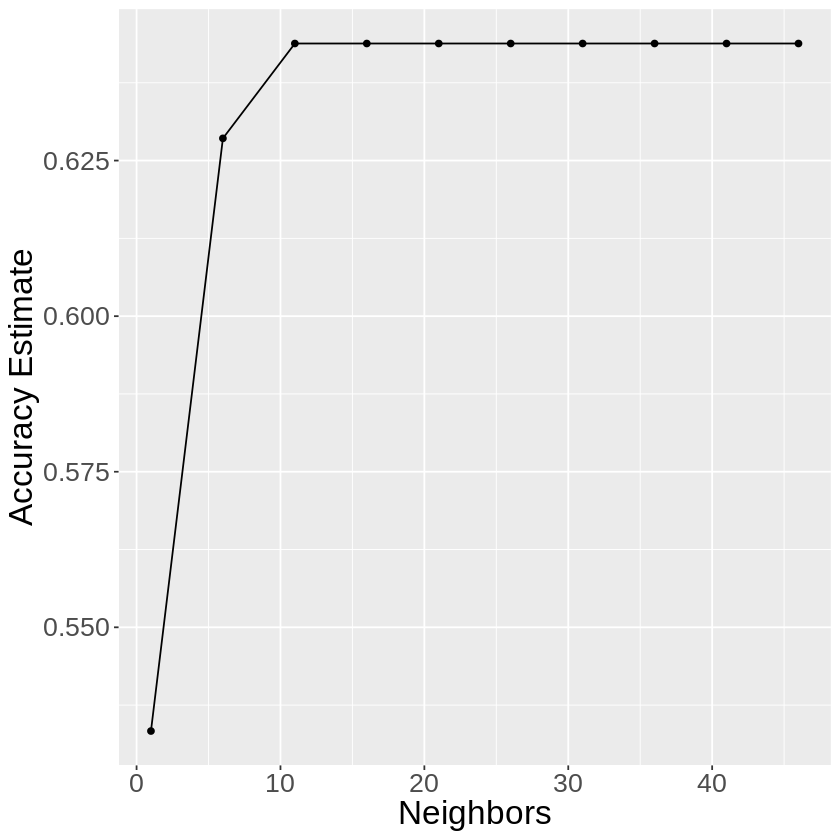

In [16]:
movies_plot <- ggplot(accuracy, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    theme(text = element_text(size = 20))
movies_plot

In [1]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

movies_recipe <- recipe(category ~ run_time + votes + imdb_rating, data = movies_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

movies_vfold <- vfold_cv(movies_train, v = 5, strata = category)

grid_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

knn_results <- workflow() |>
    add_recipe(movies_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = movies_vfold, grid = grid_vals) |>
    collect_metrics()

accuracy <- knn_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

options(repr.plot.height = 8, repr.plot.width = 20)

movies_plot <- ggplot(accuracy, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    ggtitle("Accuracy Estimate for K") +
    labs(x = "Neighbors (K)", y = "Accuracy Estimate")+
    theme(text = element_text(size = 20))

movies_plot

ERROR: Error in set_mode(set_engine(nearest_neighbor(weight_func = "rectangular", : could not find function "set_mode"
